# NFL Elimination Picks

In [1]:
import collections
import datetime
import random
import heapq
import statistics
import typing

import parsel
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [692]:
NUM_TEAMS = 32
NUM_WEEKS = 17

# http://www.espn.com/nfl/schedulegrid
raw_schedule = '''
NFL Schedule Grid
TEAM	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17
ARI	@SF	WSH	DET	@CAR	@NYJ	@DAL	SEA	BYE	MIA	BUF	@SEA	@NE	LAR	@NYG	PHI	SF	@LAR
ATL	SEA	@DAL	CHI	@GB	CAR	@MIN	DET	@CAR	DEN	BYE	@NO	LV	NO	@LAC	TB	@KC	@TB
BAL	CLE	@HOU	KC	@WSH	CIN	@PHI	PIT	BYE	@IND	@NE	TEN	@PIT	DAL	@CLE	JAX	NYG	@CIN
BUF	NYJ	@MIA	LAR	@LV	@TEN	KC	@NYJ	NE	SEA	@ARI	BYE	LAC	@SF	PIT	@DEN	@NE	MIA
CAR	LV	@TB	@LAC	ARI	@ATL	CHI	@NO	ATL	@KC	TB	DET	@MIN	BYE	DEN	@GB	@WSH	NO
CHI	@DET	NYG	@ATL	IND	TB	@CAR	@LAR	NO	@TEN	MIN	BYE	@GB	DET	HOU	@MIN	@JAX	GB
CIN	LAC	@CLE	@PHI	JAX	@BAL	@IND	CLE	TEN	BYE	@PIT	@WSH	NYG	@MIA	DAL	PIT	@HOU	BAL
CLE	@BAL	CIN	WSH	@DAL	IND	@PIT	@CIN	LV	BYE	HOU	PHI	@JAX	@TEN	BAL	@NYG	@NYJ	PIT
DAL	@LAR	ATL	@SEA	CLE	NYG	ARI	@WSH	@PHI	PIT	BYE	@MIN	WSH	@BAL	@CIN	SF	PHI	@NYG
DEN	TEN	@PIT	TB	@NYJ	@NE	MIA	KC	BYE	@ATL	@LV	LAC	NO	@KC	@CAR	BUF	@LAC	LV
DET	CHI	@GB	@ARI	NO	BYE	@JAX	@ATL	IND	@MIN	WSH	@CAR	HOU	@CHI	GB	@TEN	TB	MIN
GB	@MIN	DET	@NO	ATL	BYE	@TB	@HOU	MIN	@SF	JAX	@IND	CHI	PHI	@DET	CAR	TEN	@CHI
HOU	@KC	BAL	@PIT	MIN	JAX	@TEN	GB	BYE	@JAX	@CLE	NE	@DET	IND	@CHI	@IND	CIN	TEN
IND	@JAX	MIN	NYJ	@CHI	@CLE	CIN	BYE	@DET	BAL	@TEN	GB	TEN	@HOU	@LV	HOU	@PIT	JAX
JAX	IND	@TEN	MIA	@CIN	@HOU	DET	BYE	@LAC	HOU	@GB	PIT	CLE	@MIN	TEN	@BAL	CHI	@IND
KC	HOU	@LAC	@BAL	NE	LV	@BUF	@DEN	NYJ	CAR	BYE	@LV	@TB	DEN	@MIA	@NO	ATL	LAC
LV	@CAR	NO	@NE	BUF	@KC	BYE	TB	@CLE	@LAC	DEN	KC	@ATL	@NYJ	IND	LAC	MIA	@DEN
LAR	DAL	@PHI	@BUF	NYG	@WSH	@SF	CHI	@MIA	BYE	SEA	@TB	SF	@ARI	NE	NYJ	@SEA	ARI
LAC	@CIN	KC	CAR	@TB	@NO	NYJ	@MIA	JAX	LV	BYE	@DEN	@BUF	NE	ATL	@LV	DEN	@KC
MIA	@NE	BUF	@JAX	SEA	@SF	@DEN	LAC	LAR	@ARI	NYJ	BYE	@NYJ	CIN	KC	NE	@LV	@BUF
MIN	GB	@IND	TEN	@HOU	@SEA	ATL	BYE	@GB	DET	@CHI	DAL	CAR	JAX	@TB	CHI	@NO	@DET
NE	MIA	@SEA	LV	@KC	DEN	BYE	SF	@BUF	@NYJ	BAL	@HOU	ARI	@LAC	@LAR	@MIA	BUF	NYJ
NO	TB	@LV	GB	@DET	LAC	BYE	CAR	@CHI	@TB	SF	ATL	@DEN	@ATL	@PHI	KC	MIN	@CAR
NYG	PIT	@CHI	SF	@LAR	@DAL	WSH	@PHI	TB	@WSH	PHI	BYE	@CIN	@SEA	ARI	CLE	@BAL	DAL
NYJ	@BUF	SF	@IND	DEN	ARI	@LAC	BUF	@KC	NE	@MIA	BYE	MIA	LV	@SEA	@LAR	CLE	@NE
PHI	@WSH	LAR	CIN	@SF	@PIT	BAL	NYG	DAL	BYE	@NYG	@CLE	SEA	@GB	NO	@ARI	@DAL	WSH
PIT	@NYG	DEN	HOU	@TEN	PHI	CLE	@BAL	BYE	@DAL	CIN	@JAX	BAL	WSH	@BUF	@CIN	IND	@CLE
SF	ARI	@NYJ	@NYG	PHI	MIA	LAR	@NE	@SEA	GB	@NO	BYE	@LAR	BUF	WSH	@DAL	@ARI	SEA
SEA	@ATL	NE	DAL	@MIA	MIN	BYE	@ARI	SF	@BUF	@LAR	ARI	@PHI	NYG	NYJ	@WSH	LAR	@SF
TB	@NO	CAR	@DEN	LAC	@CHI	GB	@LV	@NYG	NO	@CAR	LAR	KC	BYE	MIN	@ATL	@DET	ATL
TEN	@DEN	JAX	@MIN	PIT	BUF	HOU	BYE	@CIN	CHI	IND	@BAL	@IND	CLE	@JAX	DET	@GB	@HOU
WSH	PHI	@ARI	@CLE	BAL	LAR	@NYG	DAL	BYE	NYG	@DET	CIN	@DAL	@PIT	@SF	SEA	CAR	@PHI
'''

class Match(collections.namedtuple("Match", "home away")):
    def __repr__(self):
        return f"<{self.__class__.__name__}: {self.away} @ {self.home}>"
    
# Match("NY", "NJ")

lines = raw_schedule.strip().splitlines()
team_lines = lines[2:]
schedule = {}
games_per_team = collections.Counter()
for tl in team_lines:
    cols = tl.split("\t")
    assert len(cols) == 18
    
    team = cols[0]
    for n_wk, match in enumerate(cols[1:], start=1):
        if match == "BYE":
            continue
        schedule.setdefault(n_wk, [])
        games_per_team[match.strip("@")] += 1
        if match.startswith("@"):
            continue  # skip to avoid double counts
        schedule[n_wk].append(Match(team, match))
    
assert all(n == 16 for n in games_per_team.values())

In [688]:
def get_espn_powers():
    data = requests.get("https://www.espn.com/nfl/fpi")
    selector = parsel.Selector(data.text)
    data_table = selector.xpath("//div[@class='Table__Scroller']/table")

    tables = selector.xpath("//div[contains(concat(' ', @class, ' '), ' league-nfl ')]//table")
    assert len(tables) == 2
    name_table, data_table = tables

    club_table = {}
    for club in name_table.xpath("descendant::*[@data-idx]"):
        club_idx = club.xpath("@data-idx").extract_first()
        club_url = club.xpath("descendant::*[@data-clubhouse-uid]/@href")
        url = club_url.extract_first()
        parts = url.split("/")
        assert parts[4] == "name"
        club_table[parts[5].strip().upper()] = int(club_idx)

    assert len(club_table) == NUM_TEAMS

    powers = {}
    for club, idx in club_table.items():
        xq = f"tbody/*[@data-idx='{idx}']"
        r = data_table.xpath(xq)
        cols = r.xpath("td/div/text()")
        pwr = float(cols[1].extract())
        powers[club] = pwr

    assert set(powers) == set(club_table)
    
    return powers

powers = get_espn_powers()

In [718]:
def print_powers(powers):
    teams = [tuple(p) for p in powers.items()]
    teams.sort(key=lambda p: p[1], reverse=True)
    print(" ".join("{:3s}".format(p[0]) for p in teams))

In [728]:
print(datetime.datetime.now().isoformat())
pd.DataFrame(powers.items())

2020-09-14T17:57:27.899335


,0,1
0,KC,7.4
1,BAL,6.0
2,NO,5.3
3,SF,4.9
4,DAL,2.8
5,SEA,2.6
6,TB,2.6
7,PHI,2.5
8,BUF,1.8
9,NE,1.6


In [730]:
# check schedule names match power names
assert set(powers) == set(games_per_team)

In [224]:
HOME_POWER_BUMP = 3.0

verb_template = "week {wk:2d}: diff {d:+5.1f} - picking {p:3s} ({ps:+3.1f}%PH%) over {vp:3s} ({vps:+3.1f}%VPH%)"


def pick_power_calculator(powers, schedule, picks, home_power=HOME_POWER_BUMP, verbose=False):
    if len(picks) != 17:
        raise ValueError("17 weeks of picks needed")
    if len(set(picks)) != 17:
        raise ValueError("unique picks needed")
    if not all(p in powers for p in picks):
        raise ValueError("unrecognized team initials")
        
    pick_powers = []
    for n_week, pick in zip(sorted(schedule), picks):
        wk_sched = schedule[n_week]
        for match in wk_sched:
            if match.home == pick:
                pick_powers.append(powers[match.home] - powers[match.away] + home_power)
                if verbose:
                    print(verb_template.replace("%PH%", "+H").replace("%VPH%", "  ").format(
                        wk=n_week,
                        d = pick_powers[-1],
                        p=match.home,
                        ps=powers[match.home],
                        vp=match.away,
                        vps=powers[match.away],
                        
                    ))
                break
            if match.away == pick:
                pick_powers.append(powers[match.away] - powers[match.home] - home_power)
                if verbose:
                    print(verb_template.replace("%VPH%", "+H").replace("%PH%", "  ").format(
                        wk=n_week,
                        d = pick_powers[-1],
                        vp=match.home,
                        vps=powers[match.home],
                        p=match.away,
                        ps=powers[match.away],
                        
                    ))
                break
        else:
            raise ValueError(f"team {pick} does not play in week {n_week}")
    return pick_powers       


def pick_grid(powers, schedule, home_bump=HOME_POWER_BUMP):
    matrix = []
    
    index = sorted(powers, key=lambda x: powers[x])
    
    for n_week, matches in sorted(schedule.items()):
        teams = {}
        for match in matches:
            teams[match.home] = powers[match.home] - powers[match.away] + home_bump
            teams[match.away] = powers[match.away] - powers[match.home] - home_bump
        week_col = [teams.get(t, -10) for t in power_rank]
        matrix.append(week_col)
    return index, matrix


In [226]:
random_pick = random.sample(list(powers), k=17)
pick_power_calculator(powers, schedule, random_pick, verbose=True)

week  1: diff  +1.7 - picking LAC (-0.7  ) over CIN (-5.4+H)
week  2: diff  +5.6 - picking CHI (-0.8+H) over NYG (-3.4  )
week  3: diff  +5.9 - picking SF  (+5.5  ) over NYG (-3.4+H)
week  4: diff  +8.7 - picking BAL (+6.1  ) over WSH (-5.6+H)
week  5: diff +11.9 - picking KC  (+7.4+H) over LV  (-1.5  )
week  6: diff  +4.5 - picking PIT (+1.1+H) over CLE (-0.4  )
week  7: diff  -2.0 - picking CIN (-5.4+H) over CLE (-0.4  )
week  8: diff  -1.7 - picking CAR (-5.0+H) over ATL (-0.3  )
week  9: diff  +3.0 - picking HOU (-1.5  ) over JAX (-7.5+H)
week 10: diff  -4.6 - picking WSH (-5.6  ) over DET (-4.0+H)
week 11: diff  +0.6 - picking NE  (+2.1  ) over HOU (-1.5+H)
week 12: diff  -1.0 - picking NYG (-3.4  ) over CIN (-5.4+H)
week 13: diff +11.4 - picking MIN (+0.9+H) over JAX (-7.5  )
week 14: diff  +3.8 - picking BUF (+1.9+H) over PIT (+1.1  )
week 15: diff  +0.8 - picking PHI (+2.7  ) over ARI (-1.1+H)
week 16: diff  -4.0 - picking IND (+0.1  ) over PIT (+1.1+H)
week 17: diff  +3.3 - pi

[1.7000000000000002,
 5.6,
 5.9,
 8.7,
 11.9,
 4.5,
 -2.0,
 -1.7000000000000002,
 3.0,
 -4.6,
 0.6000000000000001,
 -0.9999999999999996,
 11.4,
 3.8,
 0.8000000000000003,
 -4.0,
 3.3]

In [228]:
top_picks = list(powers)[:17]
pick_power_calculator(powers, schedule, top_picks, verbose=True)

week  1: diff +11.9 - picking KC  (+7.4+H) over HOU (-1.5  )
week  2: diff  +4.6 - picking BAL (+6.1  ) over HOU (-1.5+H)
week  3: diff  +5.9 - picking SF  (+5.5  ) over NYG (-3.4+H)
week  4: diff  +6.3 - picking NO  (+5.3  ) over DET (-4.0+H)
week  5: diff  +9.3 - picking DAL (+2.9+H) over NYG (-3.4  )
week  6: diff  -0.4 - picking PHI (+2.7+H) over BAL (+6.1  )
week  7: diff  +0.8 - picking SEA (+2.7  ) over ARI (-1.1+H)
week  8: diff  +2.9 - picking TB  (+2.5  ) over NYG (-3.4+H)
week  9: diff  +0.8 - picking NE  (+2.1  ) over NYJ (-1.7+H)
week 10: diff  +0.0 - picking BUF (+1.9  ) over ARI (-1.1+H)
week 11: diff  -3.9 - picking LAR (+1.6  ) over TB  (+2.5+H)
week 12: diff  -2.0 - picking PIT (+1.1+H) over BAL (+6.1  )
week 13: diff +11.4 - picking MIN (+0.9+H) over JAX (-7.5  )
week 14: diff  -1.4 - picking IND (+0.1  ) over LV  (-1.5+H)
week 15: diff  +8.0 - picking GB  (+0.0+H) over CAR (-5.0  )
week 16: diff  -3.2 - picking TEN (-0.2  ) over GB  (+0.0+H)
week 17: diff  +4.3 - pi

[11.9,
 4.6,
 5.9,
 6.300000000000001,
 9.3,
 -0.39999999999999947,
 0.8000000000000003,
 2.9000000000000004,
 0.7999999999999998,
 0.0,
 -3.9,
 -2.0,
 11.4,
 -1.4,
 8.0,
 -3.2,
 4.3]

In [289]:
top_picks = list(powers)[:17]
best_pick = None
best_pick_fitness = -100

def fitness(scores):
    return 100 * min(scores) + sum(scores)

def fitness(scores):
    return 50 * (min(scores) - 3) + sum(scores)

picks = []

HOME_POWER_BUMP = 6.0

for n in range(100_000_000):
    this_pick = top_picks[:]
    random.shuffle(this_pick)
    try:
        scores = pick_power_calculator(powers, schedule, this_pick)
    except ValueError:
        continue
    
    pick_fitness = fitness(scores)
    
    if pick_fitness < 0:
        continue

    picks.append([min(scores), sum(scores)])
    
    if pick_fitness < best_pick_fitness:
        continue
    
    print("new high score, round {:>9d}, fitness={:+3.1f}".format(n, pick_fitness))
    best_pick = this_pick
    best_scores = scores
    best_pick_fitness = pick_fitness


new high score, round    106188, fitness=+12.2
new high score, round    199061, fitness=+37.5
new high score, round    246275, fitness=+84.3
new high score, round   1678616, fitness=+87.8
new high score, round   1771856, fitness=+122.4
new high score, round  14186757, fitness=+128.1
new high score, round  63805819, fitness=+146.1


In [277]:
pick_power_calculator(powers, schedule, best_pick, verbose=True)

week  1: diff  +5.8 - picking NO  (+5.3+H) over TB  (+2.5  )
week  2: diff +10.3 - picking TEN (-0.2+H) over JAX (-7.5  )
week  3: diff  +5.6 - picking PIT (+1.1+H) over HOU (-1.5  )
week  4: diff  +3.4 - picking SEA (+2.7  ) over MIA (-3.7+H)
week  5: diff  +5.3 - picking NE  (+2.1+H) over DEN (-0.2  )
week  6: diff  +6.9 - picking SF  (+5.5+H) over LAR (+1.6  )
week  7: diff  +5.4 - picking LAR (+1.6+H) over CHI (-0.8  )
week  8: diff +12.1 - picking KC  (+7.4+H) over NYJ (-1.7  )
week  9: diff  +4.8 - picking DAL (+2.9+H) over PIT (+1.1  )
week 10: diff  +4.5 - picking TB  (+2.5  ) over CAR (-5.0+H)
week 11: diff  +3.5 - picking DEN (-0.2+H) over LAC (-0.7  )
week 12: diff  +3.3 - picking IND (+0.1+H) over TEN (-0.2  )
week 13: diff +11.4 - picking MIN (+0.9+H) over JAX (-7.5  )
week 14: diff  +3.8 - picking BUF (+1.9+H) over PIT (+1.1  )
week 15: diff  +8.0 - picking GB  (+0.0+H) over CAR (-5.0  )
week 16: diff +12.5 - picking BAL (+6.1+H) over NYG (-3.4  )
week 17: diff +11.3 - pi

[5.8,
 10.3,
 5.6,
 3.4000000000000004,
 5.300000000000001,
 6.9,
 5.4,
 12.1,
 4.8,
 4.5,
 3.5,
 3.3,
 11.4,
 3.8,
 8.0,
 12.5,
 11.3]

In [281]:
from matplotlib import pyplot as plt

In [290]:
best_scores = pick_power_calculator(powers, schedule, best_pick)
best_point = [min(best_scores), sum(best_scores)]

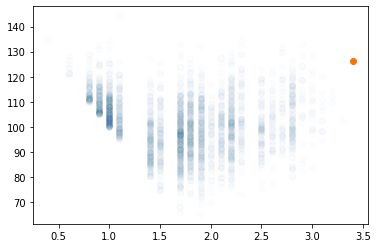

In [442]:
f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.01)

ax.scatter(*best_point, color="xkcd:orange")

(<Figure size 576x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35d04a44c0>)

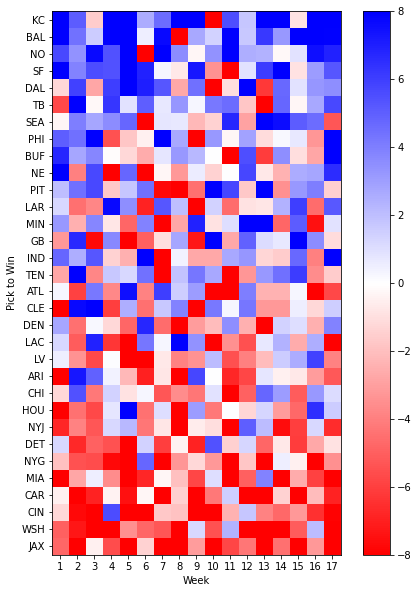

In [711]:
power_rank, matrix = pick_grid(powers, schedule, home_bump=3)

def plot_matrix(matrix, power_rank, cmap="bwr_r"):
    f, ax = plt.subplots()
    f.set_size_inches((8, 10))
    imshow = ax.imshow(np.array(matrix).T, vmax=8, vmin=-8, cmap=cmap, origin="lower")
    ax.xaxis.set_ticks(list(range(17)))
    ax.xaxis.set_ticklabels(list(range(1, 18)))
    ax.xaxis.set_label_text("Week")
    ax.yaxis.set_ticks(list(range(32)))
    ax.yaxis.set_ticklabels(power_rank)
    ax.yaxis.set_label_text("Pick to Win")

    f.colorbar(imshow)
    
    return f, ax


plot_matrix(matrix, power_rank)

(<Figure size 576x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35d02a03a0>)

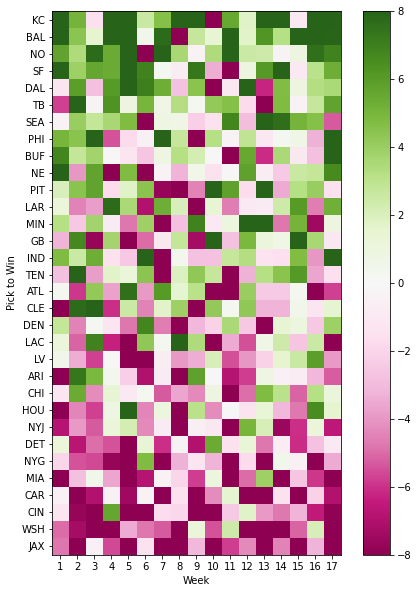

In [714]:
plot_matrix(*reversed(pick_grid(powers, schedule, home_bump=3)), cmap="PiYG")

In [685]:
class PickPermuter:
    def __init__(self, powers, schedule, home_bump=HOME_POWER_BUMP):
        self.powers = powers
        
        self.schedule = schedule
        self.home_bump = home_bump
        
        self.update_pick_grid()
        
        self.pick = self.greedy()
        
    def update_pick_grid(self):
        self.grid_index, self.grid = pick_grid(self.powers, self.schedule, self.home_bump)

    def __repr__(self):
        score = self.pick_score
#         return "<{}\n {}\n {}\n min={}, avg={}, max={}>".format(
        return "<{}\n {}\n min={}, avg={}, max={}>".format(
            self.__class__.__name__,
            ", ".join(f"{p:>2s}" for p in self.pick),
#             ", ".join(f"{p:>5s}" for p in self.pick),
#             ", ".join(f"{s:>+4.1f}" for s in score),
            min(self.pick_score),
            statistics.mean(self.pick_score),
            max(self.pick_score),
        )
        
    def greedy(self):
        picks = []
        for week in self.grid:
            best_picks = sorted(list(zip(week, self.grid_index)), reverse=True)
            for _score, pick in best_picks:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == 17
        return picks
    
    def limited_greedy(self, limit=10):
        picks = []
        for week in self.grid:
            worst_picks = sorted(list(zip(week, self.grid_index)))
            pivot_index = bisect.bisect_left(worst_picks, (limit, "X"))
            order = (worst_picks[pivot_index:] + list(reversed(worst_picks[:pivot_index])))
            for _score, pick in order:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == 17
        return picks
    
    @property
    def pick_score(self):
        return pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump)
    
    def describe_pick(self):
        pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump, verbose=True)

In [687]:
pp = PickPermuter(powers, schedule, home_bump=3)
pp.describe_pick()

week  1: diff +11.8 - picking KC  (+7.4+H) over HOU (-1.4  )
week  2: diff +10.5 - picking TEN (-0.0+H) over JAX (-7.5  )
week  3: diff +10.4 - picking PHI (+2.5+H) over CIN (-4.9  )
week  4: diff  +8.5 - picking BAL (+6.0  ) over WSH (-5.5+H)
week  5: diff +11.9 - picking SF  (+4.9+H) over MIA (-4.0  )
week  6: diff  +8.2 - picking IND (+0.3+H) over CIN (-4.9  )
week  7: diff +12.9 - picking NO  (+5.3+H) over CAR (-4.6  )
week  8: diff  +9.8 - picking LAC (-0.7+H) over JAX (-7.5  )
week  9: diff  +6.9 - picking MIN (+0.8+H) over DET (-3.1  )
week 10: diff +11.1 - picking GB  (+0.6+H) over JAX (-7.5  )
week 11: diff  +6.8 - picking SEA (+2.6+H) over ARI (-1.2  )
week 12: diff +11.3 - picking DAL (+2.8+H) over WSH (-5.5  )
week 13: diff  +9.8 - picking PIT (+1.3+H) over WSH (-5.5  )
week 14: diff  +4.8 - picking TB  (+2.6+H) over MIN (+0.8  )
week 15: diff  +6.0 - picking LAR (+1.0+H) over NYJ (-2.0  )
week 16: diff  +6.5 - picking HOU (-1.4+H) over CIN (-4.9  )
week 17: diff  +8.8 - pi

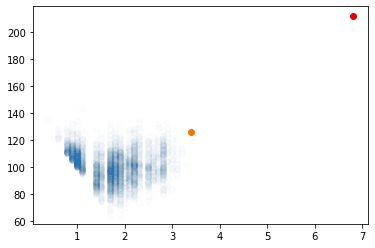

In [506]:
f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.01)

ax.scatter(*best_point, color="xkcd:orange")

ax.scatter(min(pp.pick_score), sum(pp.pick_score), color="xkcd:red")

Waaaay better with the dumb greedy algo

In [482]:
pplg = PickPermuter(powers, schedule)
pplg.pick = pplg.limited_greedy()

In [483]:
pplg.describe_pick()

week  1: diff +11.8 - picking NE  (+2.1+H) over MIA (-3.7  )
week  2: diff +10.5 - picking ARI (-1.1+H) over WSH (-5.6  )
week  3: diff +10.3 - picking LAC (-0.7+H) over CAR (-5.0  )
week  4: diff +11.0 - picking LAR (+1.6+H) over NYG (-3.4  )
week  5: diff +10.7 - picking ATL (-0.3+H) over CAR (-5.0  )
week  6: diff +11.5 - picking IND (+0.1+H) over CIN (-5.4  )
week  7: diff +11.0 - picking BAL (+6.1+H) over PIT (+1.1  )
week  8: diff +15.1 - picking KC  (+7.4+H) over NYJ (-1.7  )
week  9: diff +10.9 - picking MIN (+0.9+H) over DET (-4.0  )
week 10: diff +12.5 - picking PIT (+1.1+H) over CIN (-5.4  )
week 11: diff +11.6 - picking NO  (+5.3+H) over ATL (-0.3  )
week 12: diff +14.5 - picking DAL (+2.9+H) over WSH (-5.6  )
week 13: diff +12.1 - picking SEA (+2.7+H) over NYG (-3.4  )
week 14: diff +17.1 - picking SF  (+5.5+H) over WSH (-5.6  )
week 15: diff +11.0 - picking GB  (+0.0+H) over CAR (-5.0  )
week 16: diff  +9.9 - picking HOU (-1.5+H) over CIN (-5.4  )
week 17: diff +11.6 - pi

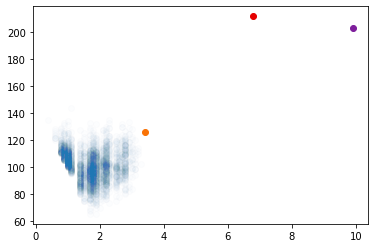

In [484]:
f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.01)

ax.scatter(*best_point, color="xkcd:orange")

ax.scatter(min(pp.pick_score), sum(pp.pick_score), color="xkcd:red")
ax.scatter(min(pplg.pick_score), sum(pplg.pick_score), color="xkcd:purple")

In [492]:
ppgh3 = PickPermuter(powers, schedule, home_bump=3)
ppgh3.pick = ppgh3.greedy()
ppgh3.describe_pick()

print("-" * 20)

pplgh3 = PickPermuter(powers, schedule, home_bump=3)
pplgh3.pick = pplgh3.limited_greedy(7)
pplgh3.describe_pick()

week  1: diff +11.9 - picking KC  (+7.4+H) over HOU (-1.5  )
week  2: diff +10.5 - picking TB  (+2.5+H) over CAR (-5.0  )
week  3: diff +11.1 - picking PHI (+2.7+H) over CIN (-5.4  )
week  4: diff  +8.7 - picking BAL (+6.1  ) over WSH (-5.6+H)
week  5: diff +12.2 - picking SF  (+5.5+H) over MIA (-3.7  )
week  6: diff  +8.5 - picking IND (+0.1+H) over CIN (-5.4  )
week  7: diff +13.3 - picking NO  (+5.3+H) over CAR (-5.0  )
week  8: diff  +9.8 - picking LAC (-0.7+H) over JAX (-7.5  )
week  9: diff  +7.9 - picking MIN (+0.9+H) over DET (-4.0  )
week 10: diff +10.5 - picking GB  (+0.0+H) over JAX (-7.5  )
week 11: diff  +6.8 - picking SEA (+2.7+H) over ARI (-1.1  )
week 12: diff +11.5 - picking DAL (+2.9+H) over WSH (-5.6  )
week 13: diff  +9.7 - picking PIT (+1.1+H) over WSH (-5.6  )
week 14: diff  +4.3 - picking TEN (-0.2  ) over JAX (-7.5+H)
week 15: diff  +6.3 - picking LAR (+1.6+H) over NYJ (-1.7  )
week 16: diff  +6.9 - picking HOU (-1.5+H) over CIN (-5.4  )
week 17: diff  +8.6 - pi

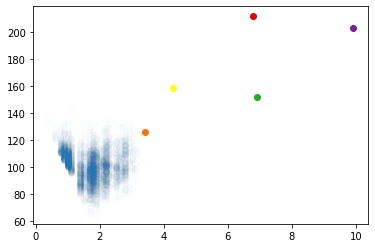

In [493]:
f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.01)

ax.scatter(*best_point, color="xkcd:orange")

ax.scatter(min(pp.pick_score), sum(pp.pick_score), color="xkcd:red")
ax.scatter(min(pplg.pick_score), sum(pplg.pick_score), color="xkcd:purple")
ax.scatter(min(ppgh3.pick_score), sum(ppgh3.pick_score), color="xkcd:yellow")
ax.scatter(min(pplgh3.pick_score), sum(pplgh3.pick_score), color="xkcd:green")

In [578]:
ppgh1 = PickPermuter(powers, schedule, home_bump=1)
ppgh1.pick = ppgh15.greedy()
ppgh1.describe_pick()

print("-" * 20)

pplgh1 = PickPermuter(powers, schedule, home_bump=1)
pplgh1.pick = pplgh1.limited_greedy(6)
pplgh1.describe_pick()

week  1: diff  +9.9 - picking KC  (+7.4+H) over HOU (-1.5  )
week  2: diff  +8.5 - picking TB  (+2.5+H) over CAR (-5.0  )
week  3: diff  +9.1 - picking PHI (+2.7+H) over CIN (-5.4  )
week  4: diff +10.7 - picking BAL (+6.1  ) over WSH (-5.6+H)
week  5: diff +10.2 - picking SF  (+5.5+H) over MIA (-3.7  )
week  6: diff  +6.5 - picking IND (+0.1+H) over CIN (-5.4  )
week  7: diff +11.3 - picking NO  (+5.3+H) over CAR (-5.0  )
week  8: diff  +7.8 - picking LAC (-0.7+H) over JAX (-7.5  )
week  9: diff  +5.9 - picking MIN (+0.9+H) over DET (-4.0  )
week 10: diff  +8.5 - picking GB  (+0.0+H) over JAX (-7.5  )
week 11: diff  +7.6 - picking PIT (+1.1  ) over JAX (-7.5+H)
week 12: diff  +9.5 - picking DAL (+2.9+H) over WSH (-5.6  )
week 13: diff  +7.1 - picking SEA (+2.7+H) over NYG (-3.4  )
week 14: diff  +6.3 - picking TEN (-0.2  ) over JAX (-7.5+H)
week 15: diff  +4.3 - picking LAR (+1.6+H) over NYJ (-1.7  )
week 16: diff  +4.9 - picking HOU (-1.5+H) over CIN (-5.4  )
week 17: diff  +6.6 - pi

In [670]:
ppv = PickPermuter(powers, schedule, home_bump=2.0)

def fitness(scores):
    return min(scores) + statistics.mean(scores) / 2

fits = []
for limiter in np.linspace(4, 10, num=100):
    ppv.pick = ppv.limited_greedy(limiter)
    fits.append((limiter, min(ppv.pick_score), statistics.mean(ppv.pick_score)))

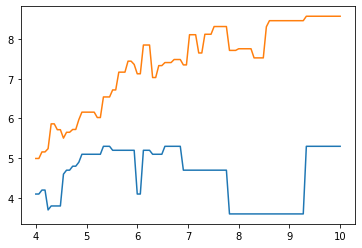

In [671]:
f, ax = plt.subplots()
x, y1, y2 = zip(*fits)
ax.plot(x, y1)
ax.plot(x, y2)

ppv.pick = ppv.greedy()
# ax.plot(10, fitness(ppv.pick_score), "bo")

In [663]:
ppv.describe_pick()

week  1: diff +10.9 - picking KC  (+7.4+H) over HOU (-1.5  )
week  2: diff  +9.5 - picking TB  (+2.5+H) over CAR (-5.0  )
week  3: diff +10.1 - picking PHI (+2.7+H) over CIN (-5.4  )
week  4: diff  +9.7 - picking BAL (+6.1  ) over WSH (-5.6+H)
week  5: diff +11.2 - picking SF  (+5.5+H) over MIA (-3.7  )
week  6: diff  +7.5 - picking IND (+0.1+H) over CIN (-5.4  )
week  7: diff +12.3 - picking NO  (+5.3+H) over CAR (-5.0  )
week  8: diff  +8.8 - picking LAC (-0.7+H) over JAX (-7.5  )
week  9: diff  +6.9 - picking MIN (+0.9+H) over DET (-4.0  )
week 10: diff  +9.5 - picking GB  (+0.0+H) over JAX (-7.5  )
week 11: diff  +6.6 - picking PIT (+1.1  ) over JAX (-7.5+H)
week 12: diff +10.5 - picking DAL (+2.9+H) over WSH (-5.6  )
week 13: diff  +8.1 - picking SEA (+2.7+H) over NYG (-3.4  )
week 14: diff  +5.3 - picking TEN (-0.2  ) over JAX (-7.5+H)
week 15: diff  +5.3 - picking LAR (+1.6+H) over NYJ (-1.7  )
week 16: diff  +5.9 - picking HOU (-1.5+H) over CIN (-5.4  )
week 17: diff  +7.6 - pi

In [672]:
ppv.pick = ppv.limited_greedy(6.6)
ppv.describe_pick()

week  1: diff  +7.8 - picking NE  (+2.1+H) over MIA (-3.7  )
week  2: diff  +7.0 - picking CLE (-0.4+H) over CIN (-5.4  )
week  3: diff  +6.9 - picking SF  (+5.5  ) over NYG (-3.4+H)
week  4: diff  +7.0 - picking LAR (+1.6+H) over NYG (-3.4  )
week  5: diff  +6.7 - picking ATL (-0.3+H) over CAR (-5.0  )
week  6: diff  +7.5 - picking IND (+0.1+H) over CIN (-5.4  )
week  7: diff  +7.0 - picking BAL (+6.1+H) over PIT (+1.1  )
week  8: diff  +8.8 - picking LAC (-0.7+H) over JAX (-7.5  )
week  9: diff  +6.9 - picking MIN (+0.9+H) over DET (-4.0  )
week 10: diff  +8.5 - picking PIT (+1.1+H) over CIN (-5.4  )
week 11: diff  +6.9 - picking KC  (+7.4  ) over LV  (-1.5+H)
week 12: diff +10.5 - picking DAL (+2.9+H) over WSH (-5.6  )
week 13: diff  +8.1 - picking SEA (+2.7+H) over NYG (-3.4  )
week 14: diff  +5.3 - picking TEN (-0.2  ) over JAX (-7.5+H)
week 15: diff  +7.0 - picking GB  (+0.0+H) over CAR (-5.0  )
week 16: diff  +6.4 - picking NO  (+5.3+H) over MIN (+0.9  )
week 17: diff  +7.6 - pi

In [674]:
ppv.pick = ppv.limited_greedy(9)
ppv.describe_pick()

week  1: diff +10.9 - picking KC  (+7.4+H) over HOU (-1.5  )
week  2: diff  +9.3 - picking TEN (-0.2+H) over JAX (-7.5  )
week  3: diff +10.1 - picking PHI (+2.7+H) over CIN (-5.4  )
week  4: diff  +9.7 - picking BAL (+6.1  ) over WSH (-5.6+H)
week  5: diff +11.2 - picking SF  (+5.5+H) over MIA (-3.7  )
week  6: diff  +7.5 - picking IND (+0.1+H) over CIN (-5.4  )
week  7: diff +12.3 - picking NO  (+5.3+H) over CAR (-5.0  )
week  8: diff  +8.8 - picking LAC (-0.7+H) over JAX (-7.5  )
week  9: diff  +6.9 - picking MIN (+0.9+H) over DET (-4.0  )
week 10: diff  +9.5 - picking GB  (+0.0+H) over JAX (-7.5  )
week 11: diff  +6.6 - picking PIT (+1.1  ) over JAX (-7.5+H)
week 12: diff +10.5 - picking DAL (+2.9+H) over WSH (-5.6  )
week 13: diff  +8.1 - picking SEA (+2.7+H) over NYG (-3.4  )
week 14: diff  +3.6 - picking TB  (+2.5+H) over MIN (+0.9  )
week 15: diff  +5.3 - picking LAR (+1.6+H) over NYJ (-1.7  )
week 16: diff  +5.9 - picking HOU (-1.5+H) over CIN (-5.4  )
week 17: diff  +7.6 - pi

## What do bettors think the home tilt is?

Not sure about the +3 being the standard home tilt, so lets try to correlate the spreads with the power rankings for week 1.

In [517]:
schedule[1]

[<Match: SEA @ ATL>,
 <Match: CLE @ BAL>,
 <Match: NYJ @ BUF>,
 <Match: LV @ CAR>,
 <Match: LAC @ CIN>,
 <Match: TEN @ DEN>,
 <Match: CHI @ DET>,
 <Match: IND @ JAX>,
 <Match: HOU @ KC>,
 <Match: DAL @ LAR>,
 <Match: GB @ MIN>,
 <Match: MIA @ NE>,
 <Match: TB @ NO>,
 <Match: PIT @ NYG>,
 <Match: ARI @ SF>,
 <Match: PHI @ WSH>]

In [524]:
match_spreads = {
    "HOU@KC": +9,
    "GB@MIN": +2.5,
    "CHI@DET": +3,
    "IND@JAX": -7.5,
    "LV@CAR": -3,
    "NYJ@BUF": +6.5,
    "SEA@ATL": -2,
    "PHI@WSH": -6,
    "MIA@NE": +6.5,
    "CLE@BAL": +8,
    "LAC@CIN": -3.5,
    "TB@NO": +3.5,
    "ARI@SF": +7,
    "DAL@LAR": -3,
    "PIT@NYG": -5.5,
    "TEN@DEN": -1.5,
}
assert len(match_spreads) == 16

In [525]:
spreads = {}
for match, spread in match_spreads.items():
    away, home = match.split("@")
    spreads[away] = spread
    spreads[home] = -spread

In [556]:
import scipy.stats

In [564]:
bumps = np.linspace(-3, 10, num=50)
pg = [pick_grid(powers, schedule, hb)[1][0] for hb in bumps]
spread_values = [-spreads[t] for t in power_rank]

fits = []
for bump, pgg in zip(bumps, pg):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pgg, spread_values)
    fits.append((bump, r_value))

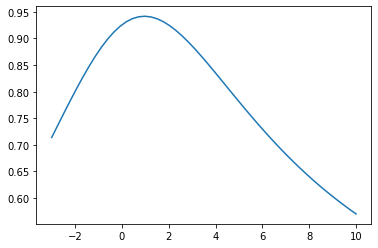

In [565]:
f, ax = plt.subplots()
ax.plot(*zip(*fits))

In [568]:
bump, r_val = max(fits, key=lambda x: x[1])
print(bump, r_val)

0.9795918367346941 0.9417638912568919


Bettors assume home bump = 1? that's seems really low...

2.571428571428572 0.9904817004176452


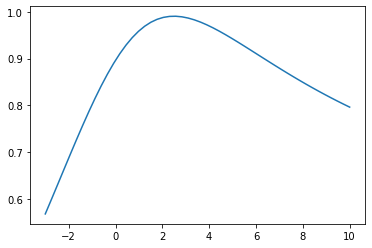

In [660]:
# https://www.thelines.com/nfl-week-2-lines-2020/
w2_matches = {
    "CIN@CLE": +7.5,
    "ATL@DAL": +7,
    "BUF@MIA": -3,
    "CAR@TB": +8.5,
    "DEN@PIT": +5.5,
    "DET@GB": +6,
    "JAX@TEN": +10.5,
    "LAR@PHI": +4,
    "MIN@IND": +3,
    "NYG@CHI": +5,
    "SF@NYJ": -5.5,
    "WSH@ARI": +6.5,
    "BAL@HOU": -5.5,
    "KC@LAC": -6.5,
    "NE@SEA": +3.5,
    "NO@LV": -4.5,
}
w2_spreads = {}
for match, spread in w2_matches.items():
    away, home = match.split("@")
    w2_spreads[away] = spread
    w2_spreads[home] = -spread
    
bumps = np.linspace(-3, 10, num=50)
pg = [pick_grid(powers, schedule, hb)[1][1] for hb in bumps]
spread_values = [-w2_spreads[t] for t in power_rank]

fits = []
for bump, pgg in zip(bumps, pg):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pgg, spread_values)
    fits.append((bump, r_value))
    
bump, r_val = max(fits, key=lambda x: x[1])
print(bump, r_val)
    
f, ax = plt.subplots()
ax.plot(*zip(*fits))

But a 2.5 bump fits best for week 2?